# Vehicle Detection and Tracking

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


**Generally, my approach in this project is starting and building on the top of the code supported in the project [lesson](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/c3e815c7-1794-4854-8842-5d7b96276642)**

In [3]:
# Importing all required libraries
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pickle
import glob
import random
import time
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, pause
%matplotlib inline

print('end')

end


## Step1: Data Loading and Exploration

In this step, I will do the following:
1. Load data
2. suffle
3. Normalize
4. split into training and test data

In [4]:
# Loading data
non_vehicles = glob.glob('./non-vehicles/**/*.png')
vehicles = glob.glob('./vehicles/**/*.png')


# Display length of datasets
print('vehicle dataset length = ', len(vehicles))
print('non-vehicle dataset length = ', len(non_vehicles))



vehicle dataset length =  8792
non-vehicle dataset length =  8968


a vehicle sample shape is  (64, 64, 3)


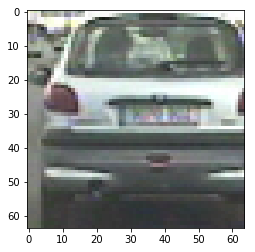

In [5]:
# Read in Random image and display shape
img = mpimg.imread(vehicles[10])
print ("a vehicle sample shape is ",img.shape)
#plt.imshow(img)
plt.imshow(img)
pause(1)


**Display samples of the dataset**

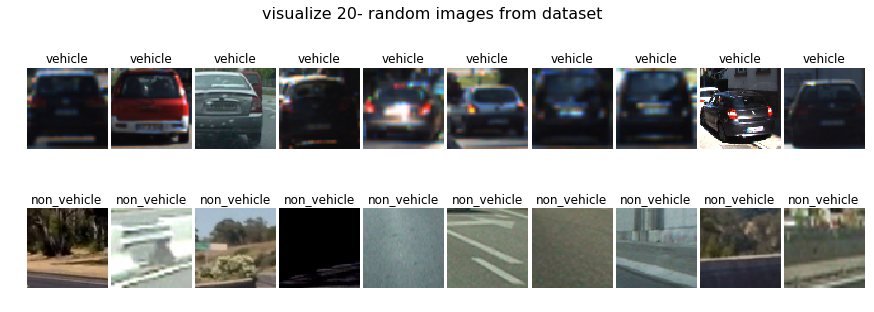

In [6]:
# Visualize 20- random images from vehicle and non-vehicle dataset

fig, axs = plt.subplots(2,10, figsize=(15, 5))
fig.subplots_adjust(hspace = .05, wspace=.05)
fig.suptitle("visualize 20- random images from dataset", fontsize=16)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(vehicles))
   # image = cv2.imread(vehicles[index])
   # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(vehicles[index]), cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title('vehicle')
for i in range(10,20):
    index = random.randint(0, len(non_vehicles))
   # image = cv2.imread(vehicles[index])
   # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(cv2.imread(non_vehicles[index]), cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].imshow(img)
    axs[i].set_title('non_vehicle')
    

    

## Step2: Features Extraction

In this step I will implement different methods for feature extraction, e.g. (Hog, color), the code used here is

In [7]:
# This function is used for coverting the image color space
# Note: This function is copied from the Udacity project lesson
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
print('end')

end


In [8]:
# This function is used for extracting Hog features
# Note: This function is copied from the Udacity project lesson
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
print('end')

end


In [9]:
# This function is used for coverting the image color space
# Note: This function is copied from the Udacity project lesson
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
print('end')

end


In [10]:
# This function is used for coverting the image color space
# Note: This function is copied from the Udacity project lesson
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
print('end')

end


**Explore Hog on vehicle images and non-vehicle images ** 

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


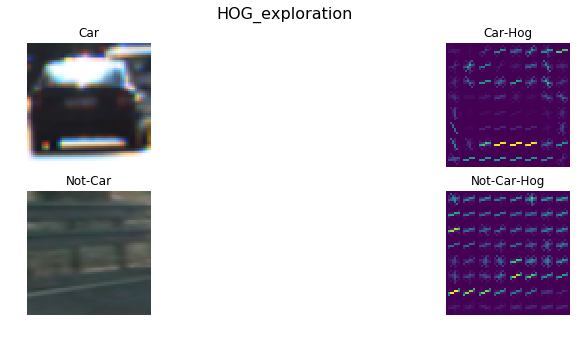

In [11]:
# Display Hog on a vehicle image and non-vehicle images
index = random.randint(0, len(vehicles))
v_img = mpimg.imread(vehicles[index]) #matplotlib read on scale from 0-->1
nv_img = mpimg.imread(non_vehicles[index])

orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # Can be 0, 1, 2, or "ALL"

v_hog_features, v_hog_image = get_hog_features(v_img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True , feature_vec=True)
nv_hog_features, nv_hog_image = get_hog_features(nv_img[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

fig, axs = plt.subplots(2,2, figsize=(15, 5))
fig.subplots_adjust(hspace = .2, wspace=.005)
fig.suptitle("HOG_exploration", fontsize=16)
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(v_img)
axs[0].set_title('Car')
axs[1].axis('off')
axs[1].imshow(v_hog_image)
axs[1].set_title('Car-Hog')
axs[2].axis('off')
axs[2].imshow(nv_img)
axs[2].set_title('Not-Car')
axs[3].axis('off')
axs[3].imshow(nv_hog_image)
axs[3].set_title('Not-Car-Hog')

## Extract hog features from a list of Images

In [12]:

# Note: This function is copied from the Udacity project lesson
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

print('end')

end


## Test on a data sample of smaller size and Normalizing (Scaling)

In [13]:
# Reduce the sample size because HOG features are slow to compute
sample_size = 500
cars = vehicles[0:sample_size]
notcars = non_vehicles[0:sample_size]
### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient,  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
print('end')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


7.74 Seconds to extract HOG features...
end


## Shuffle and split data between training and testing (20% for testing), then train a linear SVM network  and test.

In [14]:

# Note: This code  is copied from the Udacity project lesson
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print('end')

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
0.36 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  1.  0.  0.  1.]
0.00295 Seconds to predict 10 labels with SVC
end


Note: hog_channel can take values of 0, 1, 2, or "ALL", meaning that you extract HOG features from the first, second, third, or all color channels respectively.

### In this section, I will do some experiments by playing with parameters to get the better test accuracy

## Step3: Training the classifier.
Now, after getting the best feature extraction from the previous step, I will train the classifier on all the dataset.

In [15]:

cars = vehicles[0:len(vehicles)]
notcars = non_vehicles[0:len(non_vehicles)]
### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient,  pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(svc, open(filename, 'wb'))
print('end')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


140.57 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
21.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9794
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.00485 Seconds to predict 10 labels with SVC
end


## Step4: Search for car inside the image and classify using sliding windows.

In [16]:
# Note: This function is copied from the Udacity project lesson
# Ths function is used to draw boxes on the image bounded by bboxes 
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
print('end')

end


In [17]:
# Note: This function is copied from the Udacity project lesson
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=(None, None), y_start_stop=(None, None), 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list
print('end')

end


In [18]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
print('end')

end


In [19]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (128,128))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
print('end')

end


Now, I will test extract features and search windows on a single image

The code below defines a single function find_cars that's able to both extract features and make predictions.

The find_cars only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. This means that a cells_per_step = 2 would result in a search window overlap of 75%. Its possible to run this same function multiple times for different scale values to generate multiple-scaled search windows.

In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=False):
    count = 0
    t=time.time()
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:] # cut of the image only the region of interest
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

   # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 4 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangels = []
   


    for xb in range(nxsteps):
        for yb in range(nysteps):
            count +=1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
           # spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if (test_prediction == 1 or rect_display):
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangels.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    print(time.time()-t, "sec to run find_cars(), total windows= ",count )           
    return draw_img, rectangels
print('end')

end


In [21]:
# load the model from disk
svc = pickle.load(open(filename, 'rb'))
print("loaded trained model")

loaded trained model


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3.8819515705108643 sec to run find_cars(), total windows=  100
3.8778507709503174 sec to run find_cars(), total windows=  100
3.889556884765625 sec to run find_cars(), total windows=  100
3.878509759902954 sec to run find_cars(), total windows=  100
3.872133255004883 sec to run find_cars(), total windows=  100
3.8729300498962402 sec to run find_cars(), total windows=  100


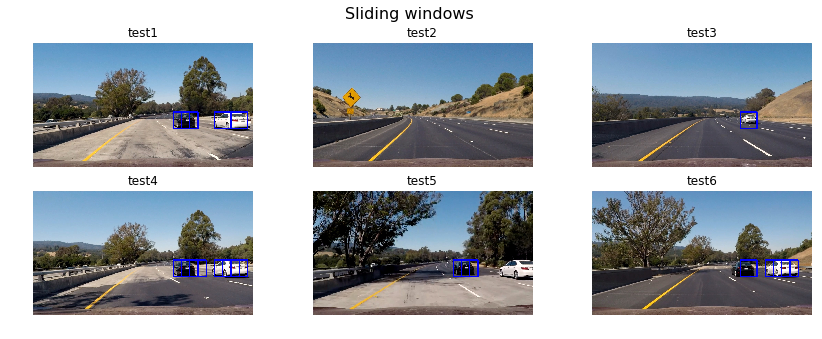

In [94]:
img1 = mpimg.imread('./test_images/test1.jpg')
img2 = mpimg.imread('./test_images/test2.jpg')
img3 = mpimg.imread('./test_images/test3.jpg')
img4 = mpimg.imread('./test_images/test4.jpg')
img5 = mpimg.imread('./test_images/test5.jpg')
img6 = mpimg.imread('./test_images/test6.jpg')




ystart = 400
ystop = 656
#xstart=0
#xstop=1280
scale = 1.5
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Note:im  my find_cars() functions, I only used hog features and deactivated color features
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
    
out_img1, bboxes1 = find_cars(img1, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img2, bboxes2 = find_cars(img2, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img3, bboxes3 = find_cars(img3, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img4, bboxes4 = find_cars(img4, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img5, bboxes5 = find_cars(img5, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img6, bboxes6 = find_cars(img6, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig, axs = plt.subplots(2,3, figsize=(15, 5))
fig.subplots_adjust(hspace = .2, wspace=.005)
fig.suptitle("Sliding windows", fontsize=16)
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(out_img1)
axs[0].set_title('test1')
axs[1].axis('off')
axs[1].imshow(out_img2)
axs[1].set_title('test2')
axs[2].axis('off')
axs[2].imshow(out_img3)
axs[2].set_title('test3')
axs[3].axis('off')
axs[3].imshow(out_img4)
axs[3].set_title('test4')
axs[4].axis('off')
axs[4].imshow(out_img5)
axs[4].set_title('test5')
axs[5].axis('off')
axs[5].imshow(out_img6)
axs[5].set_title('test6')

## Step5: Dealing with Multiple detections of the same object and false positives
Here, I will use the suggested method in the lessons to adjust the sliding windows sizes and region of interest in the image to combine duplicates and reject false positives

### Testing sliding window and car detection on test images
In this section will play with parameters to get the best areas scan in the image for the sliding windows.

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3.8368773460388184 sec to run find_cars(), total windows=  100
[((0, 400), (96, 496)), ((0, 448), (96, 544)), ((0, 496), (96, 592)), ((0, 544), (96, 640)), ((48, 400), (144, 496)), ((48, 448), (144, 544)), ((48, 496), (144, 592)), ((48, 544), (144, 640)), ((96, 400), (192, 496)), ((96, 448), (192, 544)), ((96, 496), (192, 592)), ((96, 544), (192, 640)), ((144, 400), (240, 496)), ((144, 448), (240, 544)), ((144, 496), (240, 592)), ((144, 544), (240, 640)), ((192, 400), (288, 496)), ((192, 448), (288, 544)), ((192, 496), (288, 592)), ((192, 544), (288, 640)), ((240, 400), (336, 496)), ((240, 448), (336, 544)), ((240, 496), (336, 592)), ((240, 544), (336, 640)), ((288, 400), (384, 496)), ((288, 448), (384, 544)), ((288, 496), (384, 592)), ((288, 544), (384, 640)), ((336, 400), (432, 496)), ((336, 448), (432, 544)), ((336, 496), (432, 592)), ((336, 544), (432, 640)), ((384, 400), (480, 496)), ((384, 448), (480, 544)), ((384, 496), (480, 592)), ((384, 544), (480, 640)), ((432, 400), (528, 4

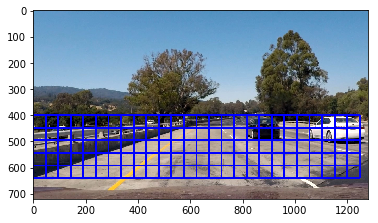

In [30]:
# Showing the region of interest
img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 656
#xstart=0
#xstop=1280
scale = 1.5
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Note:im  my find_cars() functions, I only used hog features and deactivated color features
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
    
out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=True)

print(bboxes)
#draw_img= draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
# Iterate through the bounding boxes
for bbox in bboxes:
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
plt.imshow(img )


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.0149562358856201 sec to run find_cars(), total windows=  25
[((0, 400), (96, 496)), ((48, 400), (144, 496)), ((96, 400), (192, 496)), ((144, 400), (240, 496)), ((192, 400), (288, 496)), ((240, 400), (336, 496)), ((288, 400), (384, 496)), ((336, 400), (432, 496)), ((384, 400), (480, 496)), ((432, 400), (528, 496)), ((480, 400), (576, 496)), ((528, 400), (624, 496)), ((576, 400), (672, 496)), ((624, 400), (720, 496)), ((672, 400), (768, 496)), ((720, 400), (816, 496)), ((768, 400), (864, 496)), ((816, 400), (912, 496)), ((864, 400), (960, 496)), ((912, 400), (1008, 496)), ((960, 400), (1056, 496)), ((1008, 400), (1104, 496)), ((1056, 400), (1152, 496)), ((1104, 400), (1200, 496)), ((1152, 400), (1248, 496))]


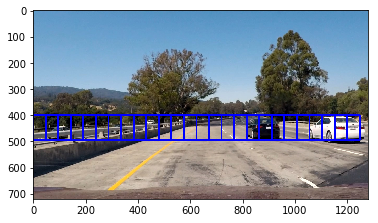

In [24]:
# After experminting (Good parameters)
img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 500
scale = 1.5
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Note:im  my find_cars() functions, I only used hog features and deactivated color features
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
    
out_img1, bboxes1 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,  rect_display=True)

print(bboxes1)
#draw_img= draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
# Iterate through the bounding boxes
for bbox in bboxes1:
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
plt.imshow(img )


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.5801589488983154 sec to run find_cars(), total windows=  39
[((0, 400), (64, 464)), ((32, 400), (96, 464)), ((64, 400), (128, 464)), ((96, 400), (160, 464)), ((128, 400), (192, 464)), ((160, 400), (224, 464)), ((192, 400), (256, 464)), ((224, 400), (288, 464)), ((256, 400), (320, 464)), ((288, 400), (352, 464)), ((320, 400), (384, 464)), ((352, 400), (416, 464)), ((384, 400), (448, 464)), ((416, 400), (480, 464)), ((448, 400), (512, 464)), ((480, 400), (544, 464)), ((512, 400), (576, 464)), ((544, 400), (608, 464)), ((576, 400), (640, 464)), ((608, 400), (672, 464)), ((640, 400), (704, 464)), ((672, 400), (736, 464)), ((704, 400), (768, 464)), ((736, 400), (800, 464)), ((768, 400), (832, 464)), ((800, 400), (864, 464)), ((832, 400), (896, 464)), ((864, 400), (928, 464)), ((896, 400), (960, 464)), ((928, 400), (992, 464)), ((960, 400), (1024, 464)), ((992, 400), (1056, 464)), ((1024, 400), (1088, 464)), ((1056, 400), (1120, 464)), ((1088, 400), (1152, 464)), ((1120, 400), (1184, 464))

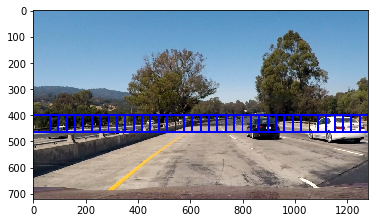

In [25]:
# After experminting (Good parameters)
img = mpimg.imread('./test_images/test1.jpg')
ystart = 400
ystop = 464
scale = 1.0
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Note:im  my find_cars() functions, I only used hog features and deactivated color features
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
    
out_img2, bboxes2 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,  rect_display=True)

print(bboxes2)
#draw_img= draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
# Iterate through the bounding boxes
for bbox in bboxes2:
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
plt.imshow(img )


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.7694871425628662 sec to run find_cars(), total windows=  19
[((0, 480), (128, 608)), ((64, 480), (192, 608)), ((128, 480), (256, 608)), ((192, 480), (320, 608)), ((256, 480), (384, 608)), ((320, 480), (448, 608)), ((384, 480), (512, 608)), ((448, 480), (576, 608)), ((512, 480), (640, 608)), ((576, 480), (704, 608)), ((640, 480), (768, 608)), ((704, 480), (832, 608)), ((768, 480), (896, 608)), ((832, 480), (960, 608)), ((896, 480), (1024, 608)), ((960, 480), (1088, 608)), ((1024, 480), (1152, 608)), ((1088, 480), (1216, 608)), ((1152, 480), (1280, 608))]


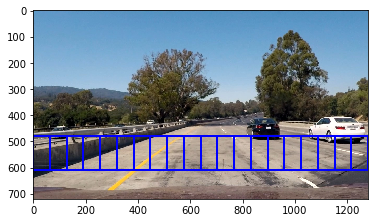

In [55]:
# After experminting (Good parameters)
img = mpimg.imread('./test_images/test1.jpg')
ystart = 480
ystop = 656
scale = 2.0
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'

# Note:im  my find_cars() functions, I only used hog features and deactivated color features
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
    
out_img3, bboxes3 = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=True)

print(bboxes3)
#draw_img= draw_boxes(img, bboxes, color=(0, 0, 255), thick=6)
# Iterate through the bounding boxes
for bbox in bboxes3:
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
plt.imshow(img )


Now as shown on test images, the classifier some times detect duplicates or false positives

In [105]:
# Modifed sliding windows function to vary the windows scale and image region
def modified_sliding_window(image, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins, rd=False):
    bboxes = []
    ystart = 400
    ystop = 500
    scale = 1.5
    
    out_img, bboxes1 = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    ystart = 400
    ystop = 464
    scale = 1.0
    
    out_img, bboxes2 = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    ystart = 480
    ystop = 656
    scale = 2.0
   
    out_img, bboxes3 = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    ystart = 432
    ystop = 600
    scale = 2.5
   
    out_img, bboxes4 = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    ystart = 420
    ystop = 550
    scale = 1.5
    
    out_img, bboxes5 = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    ystart = 410
    ystop = 480
    scale = 1.0
    
    out_img, bboxes6 = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    #ystart = 500
    #ystop = 650
   # scale = 1.5
    
    #out_img, bboxes7 = find_cars(out_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, rect_display=rd)
    
    
   
    bboxes.extend(bboxes1)
    bboxes.extend(bboxes2)
    bboxes.extend(bboxes3)
    bboxes.extend(bboxes4)
    bboxes.extend(bboxes5)  
    bboxes.extend(bboxes6) 
    bboxes.extend(bboxes7)  
    

    return out_img, bboxes

In [106]:
#Draw scanning boxes 
orient =9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
rd = True
img = np.copy(img1)
out_img, bboxes = modified_sliding_window(img, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins, rd)
for bbox in bboxes:
    # Draw a rectangle given bbox coordinates
    cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
plt.imshow(img )

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


1.011404037475586 sec to run find_cars(), total windows=  25
1.5586462020874023 sec to run find_cars(), total windows=  39
0.7960872650146484 sec to run find_cars(), total windows=  19
0.6123085021972656 sec to run find_cars(), total windows=  15
1.0297434329986572 sec to run find_cars(), total windows=  25
1.5623385906219482 sec to run find_cars(), total windows=  39


NameError: name 'bboxes7' is not defined

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


0.9944567680358887 sec to run find_cars(), total windows=  25
1.535712718963623 sec to run find_cars(), total windows=  39
0.7772352695465088 sec to run find_cars(), total windows=  19
0.6008443832397461 sec to run find_cars(), total windows=  15
1.006786584854126 sec to run find_cars(), total windows=  25
1.5285749435424805 sec to run find_cars(), total windows=  39
1.9324893951416016 sec to run find_cars(), total windows=  50
0.988065242767334 sec to run find_cars(), total windows=  25
1.5345563888549805 sec to run find_cars(), total windows=  39
0.8137528896331787 sec to run find_cars(), total windows=  19
0.5977928638458252 sec to run find_cars(), total windows=  15
1.0062592029571533 sec to run find_cars(), total windows=  25
1.5296316146850586 sec to run find_cars(), total windows=  39
1.950453281402588 sec to run find_cars(), total windows=  50
0.9889676570892334 sec to run find_cars(), total windows=  25
1.5378615856170654 sec to run find_cars(), total windows=  39
0.7797160148

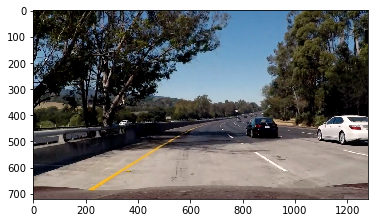

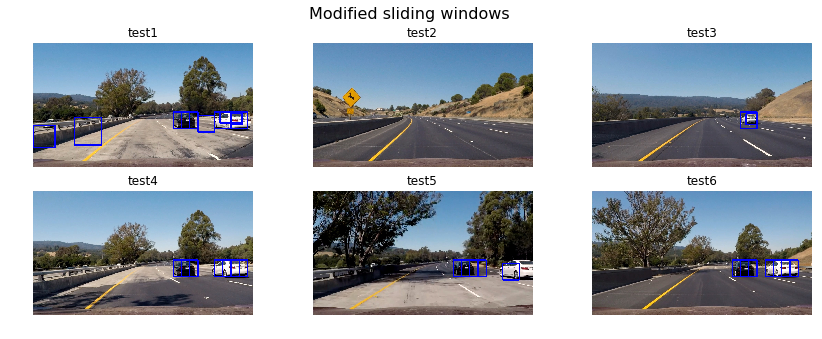

In [104]:
img1 = mpimg.imread('./test_images/test1.jpg')
plt.imshow(img5)

orient =9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'


out_img1, bboxes1 = modified_sliding_window(img1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img2, bboxes2 = modified_sliding_window(img2, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img3, bboxes3 = modified_sliding_window(img3, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img4, bboxes4 = modified_sliding_window(img4, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img5, bboxes5 = modified_sliding_window(img5, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
out_img6, bboxes6 = modified_sliding_window(img6, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig, axs = plt.subplots(2,3, figsize=(15, 5))
fig.subplots_adjust(hspace = .2, wspace=.005)
fig.suptitle("Modified sliding windows", fontsize=16)
axs = axs.ravel()
axs[0].axis('off')
axs[0].imshow(out_img1)
axs[0].set_title('test1')
axs[1].axis('off')
axs[1].imshow(out_img2)
axs[1].set_title('test2')
axs[2].axis('off')
axs[2].imshow(out_img3)
axs[2].set_title('test3')
axs[3].axis('off')
axs[3].imshow(out_img4)
axs[3].set_title('test4')
axs[4].axis('off')
axs[4].imshow(out_img5)
axs[4].set_title('test5')
axs[5].axis('off')
axs[5].imshow(out_img6)
axs[5].set_title('test6')

In [40]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
print('end')

end


then the "hot" parts of the map are where the cars are, and by imposing a threshold, I can reject areas affected by false positives. (i.e. values under the threshold is considered cold otherwise it is hot). So let's write a function to threshold the map as well.

In [41]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
print('end')

end


In [42]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


Test heat maps of  on a test images with sliding windows

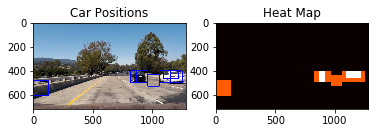

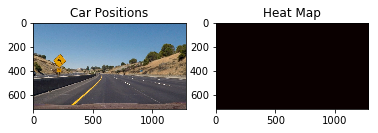

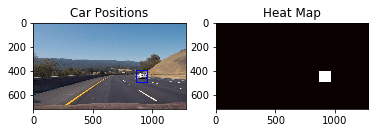

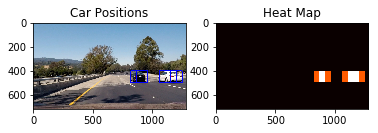

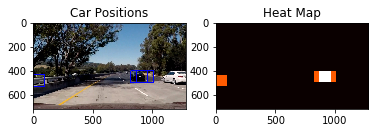

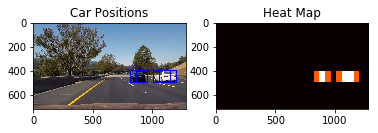

In [43]:
from scipy.ndimage.measurements import label
test = [img1,img2,img3,img4,img5,img6]
images = [out_img1,out_img2,out_img3,out_img4,out_img5,out_img6]
bboxes = [bboxes1,bboxes2,bboxes3,bboxes4,bboxes5,bboxes6]
draw_imgs = []
for i in range(len(images)):
    heat = np.zeros_like(images[i][:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes[i])
    # Apply threshold to help remove false positives
    threshold = 0 
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(test[i]), labels)
    draw_imgs.append(draw_img)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(images[i])
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    

### Drawing bounding boxes

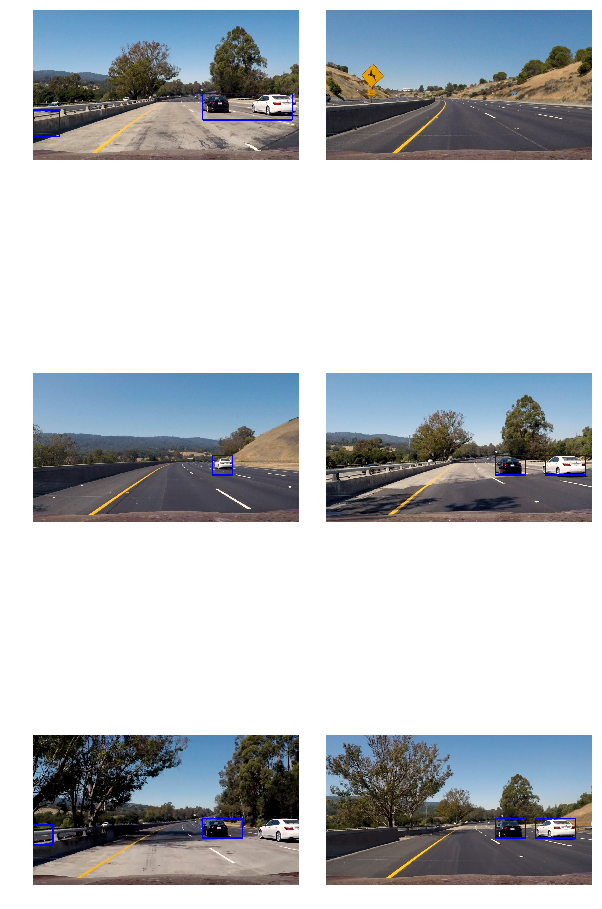

In [44]:
# Set up plot
fig, axs = plt.subplots(3,2, figsize=(10, 20))
fig.subplots_adjust(hspace = .001, wspace=.1)
axs = axs.ravel()          
for i in range(len(draw_imgs)):
               axs[i].imshow(draw_imgs[i])
               axs[i].axis('off')
               

## Step6: building a pipeline

In [45]:
def pipeline(img):
    ystart = 400
    ystop = 656
    xstart=0
    xstop=1280
    scale = 1.5
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'
    # Note:im  my find_cars() functions, I only used hog features and deactivated color features
    spatial_size = (32, 32) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins
    
    out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    threshold = 0 
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
print('end')
    

end


### Test the pipeline on test images

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


3.802288293838501 sec to run find_cars(), total windows=  100
3.800706386566162 sec to run find_cars(), total windows=  100
3.808840751647949 sec to run find_cars(), total windows=  100
3.810912609100342 sec to run find_cars(), total windows=  100
3.7933831214904785 sec to run find_cars(), total windows=  100
3.8037967681884766 sec to run find_cars(), total windows=  100


(-0.5, 1279.5, 719.5, -0.5)

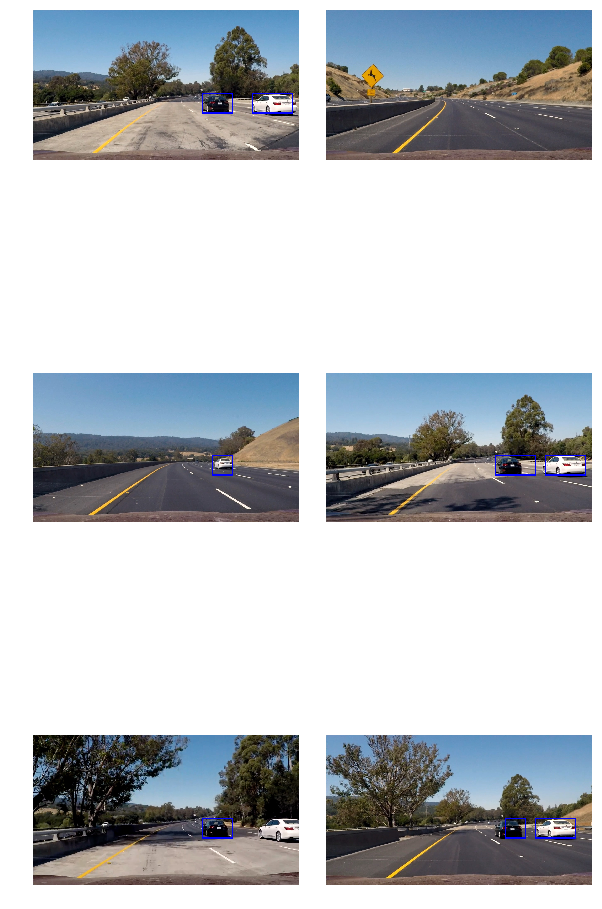

In [46]:
test_images = glob.glob('./test_images/test*.jpg')
# Set up plot
fig, axs = plt.subplots(3,2, figsize=(10, 20))
fig.subplots_adjust(hspace = .001, wspace=.1)
axs = axs.ravel() 

 
axs[0].imshow(pipeline(img1))
axs[0].axis('off')
axs[1].imshow(pipeline(img2))
axs[1].axis('off')
axs[2].imshow(pipeline(img3))
axs[2].axis('off')
axs[3].imshow(pipeline(img4))
axs[3].axis('off')
axs[4].imshow(pipeline(img5))
axs[4].axis('off')
axs[5].imshow(pipeline(img6))
axs[5].axis('off')

## Step 7: Testing on Videos
1st will test on the small one (test_video.mp4), then the project video (project_video.mp4).

In [29]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from collections import deque
print('end')

end


In [ ]:
history = deque(maxlen = 8)
output = 'test_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [ ]:
# this piece of code is used to embed the video in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}" >
</video>
""".format(output))

#### Testing on project_video.mp4

In [30]:

#history = deque(maxlen = 8)


output = 'project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip = VideoFileClip("project_video.mp4")
output_clip = clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [1:28:09<00:04,  4.13s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 1h 29min 28s, sys: 14.3 s, total: 1h 29min 42s
Wall time: 1h 28min 10s


In [31]:
# this piece of code is used to embed the video in the notebook
HTML("""
<video width="960" height="540" controls>
  <source src="{0}" >
</video>
""".format(output))

## Modified pipeline(using variable size sliding windows)

In [ ]:
def pipeline(img):
    orient =9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL'

    out_img, bboxes = modified_sliding_window(img1, svc, X_scaler, pix_per_cell, cell_per_block, spatial_size, hist_bins)
 
    heat = np.zeros_like(out_img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat, bboxes)
    # Apply threshold to help remove false positives
    threshold = 0 
    heat = apply_threshold(heat, threshold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img
print('end')